# Проект: предсказание рейтинга шоколадной плитки

## Постановка задачи:  
Мы хотим запустить производство шоколадного батончика и у нас есть выбор  из нескольких вариантов.
Мы хотим тот, который понравится потребителям.
Задача - предсказать, понравится ли шоколадная плитка потребителям. 
Предсказание будем делать на основе данных по 2300 плиток с известным рейтингом.
Шкала целевой переменной:
- 4.0 - 5.0   = Outstanding (превосходно)
- 3.5 - 3.9   = Highly Recommended (отлично)
- 3.0 - 3.49 = Recommended (хорошо)
- 2.0 - 2.9   = Disappointing (неудовлетворительно)
- 1.0 - 1.9   = Unpleasant (невкусно)  
Будем в первую очередь рассматривать эту задачу как задачу регресии и предсказывать непосредственно числовое значение рейтинга.

С другой стороны, можно было бы разделить на 2 класса: "хороший" (рейтинг больше 3) и "плохой". 
Тогда будем искать все "плохие" плитки, чтобы не допустить выпуска их в производство.
Подходящей метрикой для этой задачи будет полнота (Recall), т.е. уверенность, что мы исключили все неудачные варианты.
Но если мы сразу переведем метрики в 0 и 1, можем потерять много полезной информации.
Поеэтому будем решать задачу регресии и предсказывать не класс 0-1, а числовое значение рейтинга.


### Данные от ноября 2020 г отсюда: http://flavorsofcacao.com/chocolate_database.html

Данные:
    
   REF (**ref**) — числовое значение, показывающее, как давно ревью было добавлено в базу. Чем выше значение, тем более свежее ревью.  
   Company (Maker-if known) (**company**) — название компании, изготовившей батончик.  
   Company Location (**company_location**) — страна, в которой произведён шоколадный батончик.  
   Review Date (**review_date**) — год публикации рецензии.   
   Country of Bean Origin (**broad_origin**) — название страны, где были выращены какао-бобы.  
   Specific Bean Origin or Bar Name (**specific_origin**) — точное место происхождения какао-бобов.  
   Cocoa Percent (**cocoa_percent**) — процент какао в шоколаде.  
   Ingredients (**ingredients**) - число показывает количество ингридиентов для батончика; B = Beans, S = Sugar, S* = Sweetener other than white cane or beet sugar, C = Cocoa Butter, V = Vanilla, L = Lecithin, Sa = Salt  
   Most Memorable Characteristics (**main_character**) - ключевые характеристики  
   Rating (**rating**) — оценка батончика фокус-группой. (целевая переменная)  
    



## План работы:
   ### 0 Вспомогательные функции
   ### 1 EDA
        1.1 Работа с числовыми столбцами  
        1.2 Работа с категориальными переменными
        1.3 Текстовое поле
   ### 2 Разбивка на трейн-тест
   ### 3 Модель - Регрессия
        3.0 Наивная модель
        3.1 Random Forest
        3.2 CatBoost
        3.3 XGBoost
        3.4 Промежуточные выводы

In [1]:
import xgboost

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# data preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from gensim.models import word2vec
import pycountry
import pycountry_convert as pc

# models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

# text preprocessing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence

In [3]:
RANDOM_STATE = 23

## 0 Вспомогательные функции

In [4]:
# для оценки результатов будем смотреть в 1ю очередь на коэффициент детерминации (регрессия) и полноту (классификация)
# y_true - реальные значения
# y_pred - предсказанные значения

def print_model_result(y_true, y_pred):
    mae = metrics.mean_absolute_error(y_true, y_pred)
    rmse = metrics.mean_squared_error(y_true, y_pred, squared=False)
    r2_sc = metrics.r2_score(y_true, y_pred)
    print(' MAE:   ','RMSE:  ', 'R2_score' )
    print(round(mae, 5), round(rmse, 5), round(r2_sc, 5))
    
def print_classification_result(y_true, y_pred):
    accuracy = metrics.accuracy_score(y_true, y_pred)
    precision = metrics.precision_score(y_true, y_pred)
    recall = metrics.recall_score(y_true, y_pred)
    f1 = metrics.f1_score(y_true, y_pred)
    roc_auc = metrics.roc_auc_score(y_true, y_pred)
    print('Accur: ','Precis:', 'Recall:', 'f1_sc:', 'R_Auc' )
    print(round(accuracy, 5), 
          round(precision, 5), 
          round(recall, 5),
          round(f1, 5),
          round(roc_auc, 5))


## 1 EDA

В 1й части прочитаем данные, посмотрим на пропуски, посмотрим на распределение данных относительно целевой переменной.  
Краткое резюме по EDA:
1. пропусков почти нет (100 проусков в столбце ингридиентов 'ingredients', заполним количество их медианным значением = 3)
2. имеется дисбаланс данных: значений с рейтингом ниже 2.5  меньше, чем остальных (10% от общего числа записей

In [5]:
DATA_PATH = 'data/'
# Прочитаем данные, и для удобства работы переименуем колонки
df_raw = pd.read_csv((DATA_PATH + 'cacao_new.csv'), sep = ';')
df_raw.columns = ['ref', 'company', 'company_location', 'review_date', 'broad_origin', 'specific_origin', 'cocoa_percent', 
                  'ingredients', 'main_character', 'rating']
# Сохраним оригинальный датасет в переменной df_raw, в дальнейшем для работы будем использовать df
# У нас всего 2333 записей, из них есть немного пропусков в колонке ингридиентов. В целом данные выглядят хорошими
df = df_raw.copy()
display(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2333 entries, 0 to 2332
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ref               2333 non-null   int64  
 1   company           2333 non-null   object 
 2   company_location  2333 non-null   object 
 3   review_date       2333 non-null   int64  
 4   broad_origin      2333 non-null   object 
 5   specific_origin   2333 non-null   object 
 6   cocoa_percent     2333 non-null   object 
 7   ingredients       2245 non-null   object 
 8   main_character    2333 non-null   object 
 9   rating            2333 non-null   float64
dtypes: float64(1), int64(2), object(7)
memory usage: 182.4+ KB


None

,ref,company,company_location,review_date,broad_origin,specific_origin,cocoa_percent,ingredients,main_character,rating
0,2454,5150,U.S.A.,2019,Madagascar,"Bejofo Estate, batch 1",76%,"3- B,S,C","cocoa, blackberry, full body",3.75
1,2458,5150,U.S.A.,2019,Dominican Republic,"Zorzal, batch 1",76%,"3- B,S,C","cocoa, vegetal, savory",3.50
2,2454,5150,U.S.A.,2019,Tanzania,"Kokoa Kamili, batch 1",76%,"3- B,S,C","rich cocoa, fatty, bready",3.25
3,797,A. Morin,France,2012,Peru,Peru,63%,"4- B,S,C,L","fruity, melon, roasty",3.75
4,797,A. Morin,France,2012,Bolivia,Bolivia,70%,"4- B,S,C,L","vegetal, nutty",3.50
5,1015,A. Morin,France,2013,Venezuela,Chuao,70%,"4- B,S,C,L","oily, nut, caramel, raspberry",4.00
6,1019,A. Morin,France,2013,Peru,Chanchamayo Province,63%,"3- B,S,C","sweet, cocoa, tangerine",4.00
7,1011,A. Morin,France,2013,Ecuador,Equateur,70%,"4- B,S,C,L","sandy, nutty, cocoa, fig",3.75
8,1019,A. Morin,France,2013,Peru,Chanchamayo Province,70%,"4- B,S,C,L","cocoa,sour,intense tangerine",3.50
9,1011,A. Morin,France,2013,Brazil,Brazil,70%,"4- B,S,C,L",mild tobacco,3.25


### 1.1 Работа с числовыми столбцами  
Числовые столбцы (и те, которые могут быть к ним приведены):  
**rating** 
**ref**  
**review_date**  
**cocoa_percent**  
**no_ingred**  - выделим отдельный признак для количества ингредиентов

### 1.1.1 Целевая переменная  
Исходной целевой переменной является рейтинг - совокупная оценка плитки по 5-ти балльной шкале.  
**rating** - меняется от 1 до 4 с шагом 0.25  
По экспериментам, оказалось сложно добиться приемлемого качетсва модели (возможно, целевая переменная вообще никак не связана с данными из таблицы). Максимсльный на 21.01. коэффициент детерминации - 0.24 (приемлемый - 0.5, т.е. когда больше половины внтренних зависимостей удалось включить в модель)

Разобьем данные на два класса:

**target** - бинарная классификация:   
Цель - выявить плохой шоколад, чтобы не выпустить на рынок продукт, который не будут покупать.
Т.е. метрика - Recall, найти все 1, даже если ошибочно исключим из производства хороший шоколад
- 1 (плохой) если rating от 1.0  до 2.9  
- 0 (хороший) rating от 3 до 5



Минимальная оценка: 1.0 Максимальная оценка: 4.0


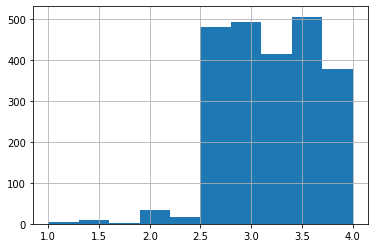

In [6]:
# Целевая переменная.
# Видим, что отсутствуют шоколадные плитки превосходного качества, максимальная оценка -4
print('Минимальная оценка:', df.rating.min(), 'Максимальная оценка:', df.rating.max())
df.rating.hist()

In [7]:
# создадим список с наименованиями целевыми переменными, чтобы удалять эти столбцы из тренировочной выборки
targets = ['rating', 'target']
df['target'] = df['rating'].apply(lambda x: 1 if x < 2.9 else 0) #для бинарной классификации - 1 это плохие

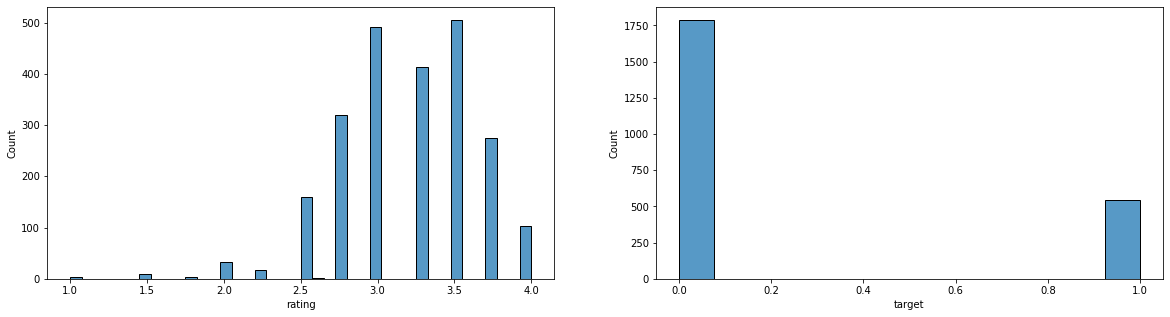

In [8]:
# Нарисуем распределения таргетов. Распределение визуально похоже на нормальное, а соотношение класслв 1 и 0 - примерно 1 к 3.
figure = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.histplot(df.rating)
plt.subplot(1, 2, 2)
sns.histplot(df.target)

### 1.1.2 Cocoa_percent

In [9]:
# создадим списки столбцов по группам
features_numerical = ['cocoa_percent', 'no_ingred'] # чисто числовые признаки
features_categorical = [] # категориальные для Катбуст, где в каждой строке по одной категории. Ингридиенты сюда не будут относиться
features_dummies =[] # фиктивные переменные, соответствующие features_categorical

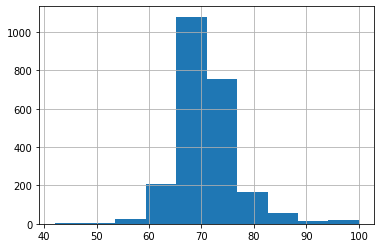

In [10]:
# Переведем в числовой тип значения в cocoa_percent и посмотрим на них:
df.cocoa_percent = df.cocoa_percent.apply(lambda x: x[:-1]).astype(float)
df.cocoa_percent.hist() # похоже не нормальное

In [11]:
# Какие значения чаще всего встречаются?
print('Среднее: ', df.cocoa_percent.mean(), ' Медиана: ', df.cocoa_percent.median())
df.cocoa_percent.value_counts().head(5)

Среднее:  71.63759108444063  Медиана:  70.0


70.0    946
75.0    289
72.0    263
65.0     89
80.0     84
Name: cocoa_percent, dtype: int64

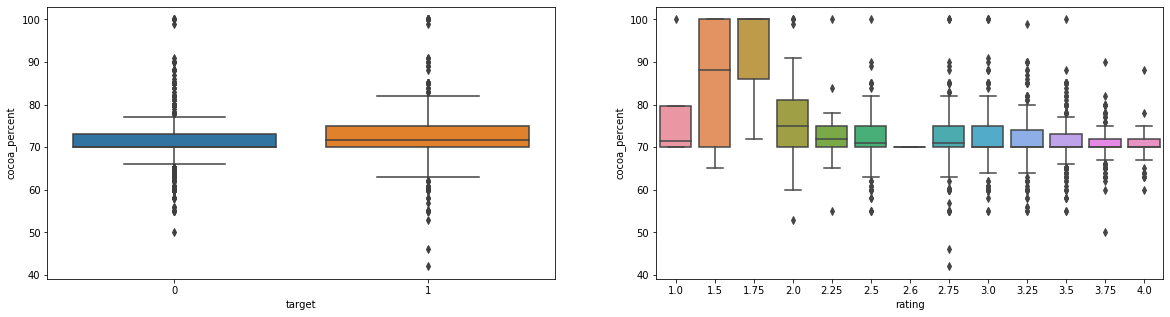

In [12]:
# как зависит рейтинг от процента какао? --> высокий процент какао в среднем получает более низкие оценки
figure = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df.target, y = df.cocoa_percent)
plt.subplot(1, 2, 2)
sns.boxplot(x=df.rating, y = df.cocoa_percent)
plt.show()

In [13]:
df.groupby(by='target')['cocoa_percent'].mean()

target
0    71.316172
1    72.689560
Name: cocoa_percent, dtype: float64

Остаются два числовых столбца: ref и review_date. Судя по их гистрограммам, данные распределены равномерно, выбросов нет, пропусков тоже

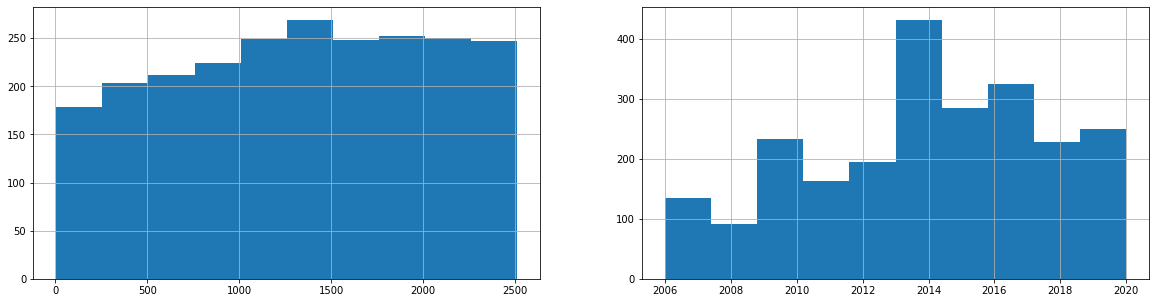

In [14]:
figure = plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
df.ref.hist()
plt.subplot(1, 2, 2)
df.review_date.hist()
plt.show()


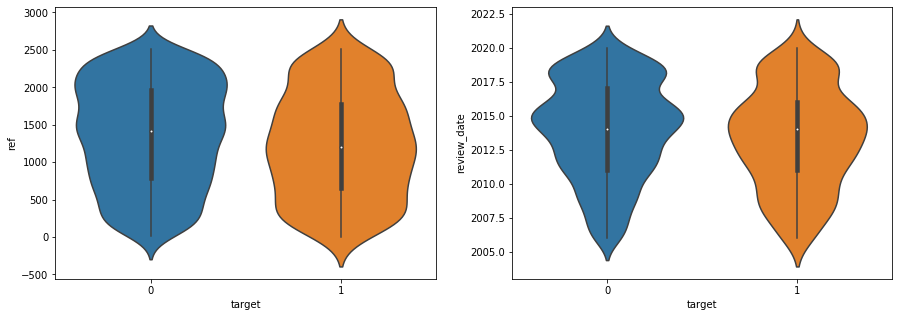

In [15]:
figure = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.violinplot(x=df.target, y = df.ref)
plt.subplot(1, 2, 2)
sns.violinplot(x=df.target, y = df.review_date)
plt.show()
# 

In [16]:
# в ингредиентах есть 88 пропущенных значений. 
# Формат записи - первым значением идет количество ингридиетсов, зате в зашифрованном виде сами ингредиенты.
# Заполним только КОЛИЧЕСТВО ингредиентов, наиболее часто встречающимся значением (это будет 3)
df['ingredients'].fillna(df[df.ingredients.notna()]['ingredients'].apply(lambda x: x[:1]).value_counts().index[0], inplace=True)
# выделим в новый признак количество ингридиентов
df['no_ingred'] = df['ingredients'].apply(lambda x: x[:1]).astype(int)

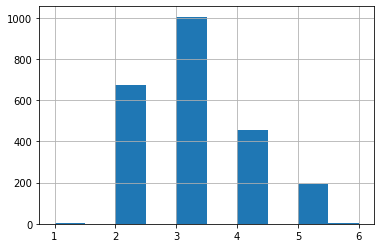

In [17]:
df['no_ingred'].hist() # нормальное распределение

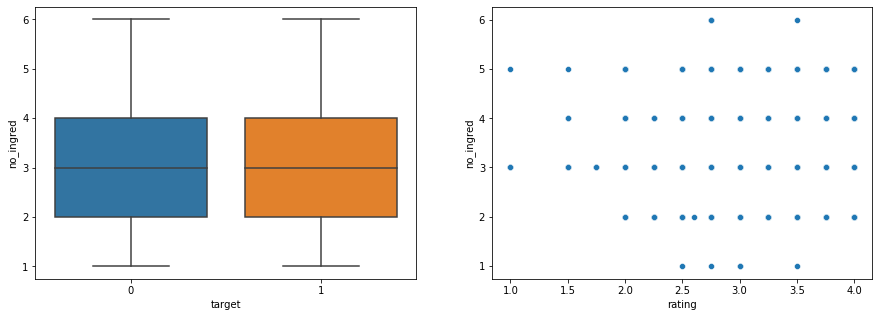

In [18]:
# есть ли зависимость между количеством ингедиентов и рейтингом? --> не похоже, что есть такая зависимость
figure = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df.target, y = df.no_ingred)
plt.subplot(1, 2, 2)
sns.scatterplot(x=df.rating, y = df.no_ingred)
plt.show()  

In [19]:
# Посмотрим на корреляцию между числовыми переменными. Видим высокую корреляцию между ref и review_date. 
display(df.corr())
# удалим review_date, потому что в нем меньшe разброс числовых значений
df.drop('ref', axis = 1, inplace=True)
if 'review_date' not in features_numerical: features_numerical.append('review_date')

,ref,review_date,cocoa_percent,rating,target,no_ingred
ref,1.000000,0.991849,0.017893,0.087621,-0.081712,-0.340158
review_date,0.991849,1.000000,0.018616,0.089978,-0.080279,-0.349529
cocoa_percent,0.017893,0.018616,1.000000,-0.151842,0.101258,-0.171214
rating,0.087621,0.089978,-0.151842,1.000000,-0.748112,-0.087307
target,-0.081712,-0.080279,0.101258,-0.748112,1.000000,0.058227
no_ingred,-0.340158,-0.349529,-0.171214,-0.087307,0.058227,1.000000


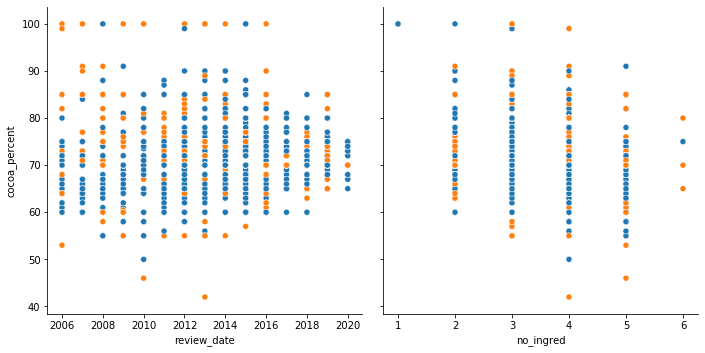

In [20]:
g = sns.PairGrid(data=df,
                 x_vars=['review_date', 'no_ingred'],
                 y_vars=['cocoa_percent'],
                 hue='target',
                 height=5)
g.map(sns.scatterplot); # визуально не видно кластеров

### 1.2 Работа с категориальными переменными  
Остаются следующие категориальные переменные:  
**company** — название компании, изготовившей батончик.  
**specific_origin** — точное место происхождения какао-бобов.  
**broad_origin** — название региона, где были выращены какао-бобы.  
**company_location** — страна, в которой произведён шоколадный батончик  
**ingredients** - перечень ингредиентов.   
Могут быть 7 шт:  
B = Beans,  
            S = Sugar,   
            S* = Sweetener other than white cane or beet sugar,   
            C = Cocoa Butter,   
            V = Vanilla,   
            L = Lecithin,   
            Sa = Salt

In [21]:
# Посмотрим на наименование фирмы-изготовителя. Видим, что у нас 543 уникальных наименования
# пропусков нет
display(df.company.unique())

array(['5150', 'A. Morin', 'Acalli', 'Adi aka Fijiana (Easy In Ltd)',
       'Aelan', 'Aequare (Gianduja)', 'Ah Cacao', "Akesson's (Pralus)",
       'Alain Ducasse', 'Alexandre', 'Altus aka Cao Artisan', 'Amano',
       'Amatller (Simon Coll)', 'Amazing Cacao', 'Amazona', 'Ambrosia',
       'Amedei', 'AMMA', 'Anahata', 'Animas', 'Ara', 'Arete', 'Argencove',
       'Artisan du Chocolat', 'Artisan du Chocolat (Casa Luker)',
       'Askinosie', 'Atypic', 'Auro', 'Bahen & Co.', 'Baiani', 'Bakau',
       'Bankston', 'Bar Au Chocolat', "Baravelli's", 'Batch', 'Bean',
       'Beau Cacao', 'Beehive', 'Belcolade', 'Bellflower', 'Belvie',
       'Belyzium', 'Benns', 'Benoit Nihant', 'Bernachon',
       'Beschle (Felchlin)', 'Bisou', 'Bitacora', 'Bittersweet Origins',
       'Bixby', 'Black Mountain', 'Black River (A. Morin)', 'Blanxart',
       'Blue Bandana', 'Boho', 'Bonaterra', 'Bonnat',
       'Bouga Cacao (Tulicorp)', 'Bowler Man',
       'Chocolates by Josh (Box Chocolate)', 'Brasstown',
 

In [22]:
# Посчитаем для каждой компании количество продуктов, которые она уже выпускает на рынок

In [23]:
# добавим количество наименований плиток, которые производит данная фирма, в список числовых столбцов
if 'no_products' not in features_numerical: features_numerical.append('no_products')
df['no_products'] = df['company'].apply(lambda x: df['company'].value_counts()[x])

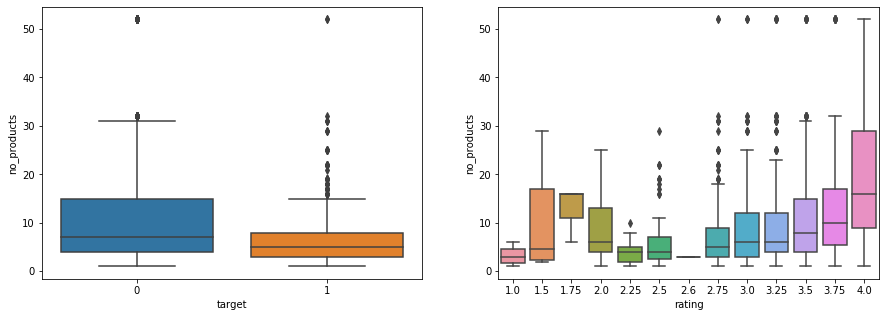

In [24]:
df.drop('company', axis=1, inplace=True)

figure = plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
sns.boxplot(x=df.target, y = df.no_products)
plt.subplot(1, 2, 2)
sns.boxplot(x=df.rating, y = df.no_products)
plt.show()
# рейтинг выше у фирм, которые больше плиток производят

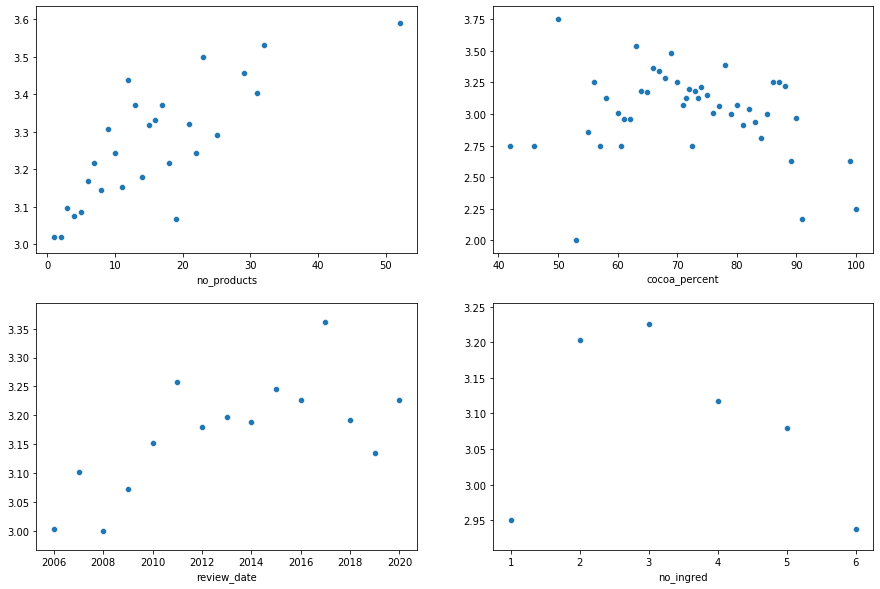

In [25]:
# посмотрим на зависимость среднего рейтинга от числовых переменных
# видим, что есть зависимость от количества шоколадных плиток у фирмы и количества ингридиентов
figure = plt.figure(figsize=(15,10))
plt.subplot(2, 2, 1)
sns.scatterplot(x = df.groupby(by = 'no_products')['rating'].mean().index, 
                y = df.groupby(by = 'no_products')['rating'].mean().values)
plt.subplot(2, 2, 2)
sns.scatterplot(x = df.groupby(by = 'cocoa_percent')['rating'].mean().index, 
                y = df.groupby(by = 'cocoa_percent')['rating'].mean().values)
plt.subplot(2, 2, 3)
sns.scatterplot(x = df.groupby(by = 'review_date')['rating'].mean().index, 
                y = df.groupby(by = 'review_date')['rating'].mean().values)
plt.subplot(2, 2, 4)
sns.scatterplot(x = df.groupby(by = 'no_ingred')['rating'].mean().index, 
                y = df.groupby(by = 'no_ingred')['rating'].mean().values)
plt.show()


In [26]:
# Столбец specific_origin - точный регион происхождения какао-бобов
# Сколько в нем уникальных значений?
df.specific_origin.nunique()
# В столбце specific_origin 1452 уникальных значений. 
# Удалим его, в таком виде информации недостаточно для предсказания рейтинга

1452

In [27]:
df.drop('specific_origin', axis=1, inplace=True)

In [28]:
# В информации по странам происхожнения бобов 61 уникальных значений. 
# Данные в хорошем виде, пропусков нет, подправим только наименовения стран

print('Уникальных значений в стране происхождения бобов: ', df.broad_origin.nunique())
df.broad_origin.unique()

Уникальных значений в стране происхождения бобов:  61


array(['Madagascar', 'Dominican Republic', 'Tanzania', 'Peru', 'Bolivia',
       'Venezuela', 'Ecuador', 'Brazil', 'Papua New Guinea', 'Burma',
       'Panama', 'Colombia', 'Cuba', 'Togo', 'Sao Tome', 'Mexico', 'Fiji',
       'Vanuatu', 'Indonesia', 'Trinidad', 'Vietnam', 'Nicaragua',
       'Ghana', 'Belize', 'Blend', 'Grenada', 'Jamaica', 'Guatemala',
       'Costa Rica', 'Honduras', 'Haiti', 'India', 'Congo', 'Philippines',
       'Solomon Islands', 'Uganda', 'Malaysia', 'Sri Lanka',
       'Ivory Coast', 'Gabon', 'Taiwan', 'Puerto Rico', 'Martinique',
       'St. Lucia', 'Australia', 'Liberia', 'Sierra Leone', 'U.S.A.',
       'Nigeria', 'St.Vincent-Grenadines', 'Thailand', 'Tobago',
       'Sumatra', 'El Salvador', 'Cameroon', 'Samoa',
       'Sao Tome & Principe', 'Principe', 'Sulawesi', 'Suriname',
       'DR Congo'], dtype=object)

Обработаем эти данные следующим образом:  
1. Приведем к единообразному написанию все наименования стран
2. Приведем к единообразоному написанию (с разделителем ',') данные, где указано несколько стран
3. Преобразуем в dummies-переменные

In [29]:
df.broad_origin = df.broad_origin.astype(str).apply(lambda x: np.nan if x.strip() == '' else x)


# очистим данные по странам. Приведем в вид: уникальные названия стран, через запятую.
alias_dict = dict()
for alias in ['Sao Tome & Principe', 'Principe', 'Sao Tome']:
    alias_dict[alias] = 'Sao Tome and Principe'
for alias in ['Trinidad', 'Tobago']:
    alias_dict[alias] = 'Trinidad and Tobago'
for alias in ['Burma']:
    alias_dict[alias] = 'Myanmar'
for alias in ['U.S.A.']:
    alias_dict[alias] = 'USA'
for alias in ['St.Vincent-Grenadines']:
    alias_dict[alias] = 'St. Vincent and The Grenadines'
for alias in ['DR Congo']:
    alias_dict[alias] = 'Congo'
for alias in ['Sumatra', 'Sulawesi']:
    alias_dict[alias] = 'Indonesia'
# функция для приведения перечня стран происхождения в единообразный вид:
def clean_countries(x):
    for alias in alias_dict.keys():
        if alias in x.split(','):
            x = x.replace(alias, alias_dict[alias])
    return x

df.broad_origin = df.broad_origin.astype(str).apply(clean_countries)

In [30]:
print('Уникальных значений в стране происхождения бобов: ', df.broad_origin.nunique())
df.broad_origin.unique()

Уникальных значений в стране происхождения бобов:  55


array(['Madagascar', 'Dominican Republic', 'Tanzania', 'Peru', 'Bolivia',
       'Venezuela', 'Ecuador', 'Brazil', 'Papua New Guinea', 'Myanmar',
       'Panama', 'Colombia', 'Cuba', 'Togo', 'Sao Tome and Principe',
       'Mexico', 'Fiji', 'Vanuatu', 'Indonesia', 'Trinidad and Tobago',
       'Vietnam', 'Nicaragua', 'Ghana', 'Belize', 'Blend', 'Grenada',
       'Jamaica', 'Guatemala', 'Costa Rica', 'Honduras', 'Haiti', 'India',
       'Congo', 'Philippines', 'Solomon Islands', 'Uganda', 'Malaysia',
       'Sri Lanka', 'Ivory Coast', 'Gabon', 'Taiwan', 'Puerto Rico',
       'Martinique', 'St. Lucia', 'Australia', 'Liberia', 'Sierra Leone',
       'USA', 'Nigeria', 'St. Vincent and The Grenadines', 'Thailand',
       'El Salvador', 'Cameroon', 'Samoa', 'Suriname'], dtype=object)

In [31]:
# добавим переменную, которая означает, местный шоколад или нет
if 'is_local' not in features_numerical: features_numerical.append('is_local')
df['is_local'] = (df.company_location == df.broad_origin).astype(int)

In [32]:
# есть популярные страны, а есть страны, где только один продукт представлен.
# Оставим в значимых переменных только 10 наиболее популярных мест происхождения, остальные отметим как "other"
if 'cat_broad_origin' not in features_categorical: features_categorical.append('cat_broad_origin')
most_pop_broad = list(df['broad_origin'].value_counts()[:10].index)
df['cat_broad_origin'] = df['broad_origin'].apply(lambda x: x if x in most_pop_broad else 'other')

In [33]:
# добавим dummy-variables, где 1 будет соответствовать стране происхождения бобов
df_cat_broad_origin = pd.get_dummies(df.cat_broad_origin)
features_dummies.extend(df_cat_broad_origin.columns)
df = df.join(df_cat_broad_origin)


In [34]:
# Страна фирмы-изготовителя - -67 уникальных значений, пропусков нет
df.company_location.nunique(), df.company_location.isna().sum()

(67, 0)

In [35]:
# оставим только 10 наиболее частто встречающихся стран расположения компаний
if 'cat_location' not in features_categorical: features_categorical.append('cat_location')
most_pop_location = list(df['company_location'].value_counts()[:30].index)
df['cat_location'] = df['company_location'].apply(lambda x: x if x in most_pop_broad else 'other')

In [36]:
df_cat_location = pd.get_dummies(df.cat_location, prefix='comp')
features_dummies.extend(df_cat_location.columns)

df = df.join(df_cat_location)
df.drop('company_location', axis=1, inplace=True)

In [37]:
# добавим название континента
def continent_name(country):
    try:
        county_code = pc.country_name_to_country_alpha2(country)
        continent_name = pc.country_alpha2_to_continent_code(county_code)
    except:
        continent_name = 'UN'
    return continent_name

df['continent'] = df['broad_origin'].apply(continent_name)
if 'continent' not in features_categorical: features_categorical.append('continent')

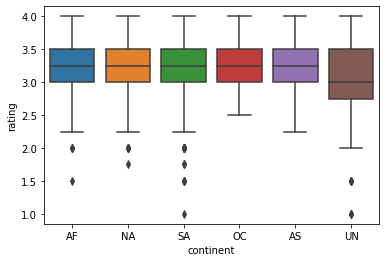

In [38]:
sns.boxplot(x=df.continent, y = df.rating) #нет большой зависимости, только для неизвестных стран ("бленд") рейтинг ниже

In [39]:
df_cat_continent = pd.get_dummies(df.continent, prefix='cont')
features_dummies.extend(df_cat_continent.columns)

df = df.join(df_cat_continent)

In [40]:
df.drop('broad_origin', axis=1, inplace=True)

In [41]:
# Разберем еще список ингредиентов
df.ingredients.value_counts()

3- B,S,C          894
2- B,S            641
4- B,S,C,L        273
5- B,S,C,V,L      184
4- B,S,C,V        139
3                  88
2- B,S*            31
4- B,S*,C,Sa       20
3- B,S*,C          12
3- B,S,L            8
4- B,S*,C,V         7
5-B,S,C,V,Sa        6
4- B,S,V,L          5
1- B                5
4- B,S,C,Sa         5
6-B,S,C,V,L,Sa      4
4- B,S*,V,L         3
3- B,S,V            3
4- B,S*,C,L         2
5- B,S,C,L,Sa       1
2- B,C              1
3- B,S*,Sa          1
Name: ingredients, dtype: int64

In [42]:
all_ingredients = 'B,S,S*,C,V,L,Sa'.split(',')
for item in all_ingredients:
    features_dummies.append('ingr_' + item)
    df['ingr_' + item] = df['ingredients'].apply(lambda x: 1 if item in x else 0)

In [43]:
df.drop(['ingredients'], axis=1, inplace=True)

In [44]:
# Посмотрим, какие категориальные фичи для Катбуста у нас получились
df[features_categorical]

,cat_broad_origin,cat_location,continent
0,Madagascar,other,AF
1,Dominican Republic,other,NA
2,other,other,AF
3,Peru,other,SA
4,Bolivia,other,SA
...,...,...,...
2328,Blend,other,UN
2329,Colombia,other,SA
2330,other,other,NA
2331,other,other,AF


### 1.3 Обработка текста

In [45]:
# У нас есть еще текстовое поле, где описаны основные вкусовые характеристики. 
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 800
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 10

In [46]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(df.main_character)

Wall time: 62.8 ms


In [47]:
%%time
text_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(df.main_character), maxlen=MAX_SEQUENCE_LENGTH)

print(text_sequences.shape)

(2333, 10)
Wall time: 65.8 ms


In [48]:
features_numerical.extend(pd.DataFrame(text_sequences).columns)

In [49]:
df.drop('main_character', axis=1, inplace=True)

In [50]:
df = df.join(pd.DataFrame(text_sequences))

In [51]:
# Итоговый датасет
df

,review_date,cocoa_percent,rating,target,no_ingred,no_products,is_local,cat_broad_origin,Blend,Bolivia,...,0,1,2,3,4,5,6,7,8,9
0,2019,76.0,3.75,0,3,3,0,Madagascar,0,0,...,0,0,0,0,0,0,1,136,190,314
1,2019,76.0,3.50,0,3,3,0,Dominican Republic,0,0,...,0,0,0,0,0,0,0,1,48,106
2,2019,76.0,3.25,0,3,3,0,other,0,0,...,0,0,0,0,0,0,15,1,12,191
3,2012,63.0,3.75,0,4,25,0,Peru,0,0,...,0,0,0,0,0,0,0,34,69,5
4,2012,70.0,3.50,0,4,25,0,Bolivia,0,1,...,0,0,0,0,0,0,0,0,48,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,2014,80.0,2.75,1,4,21,0,Blend,1,0,...,0,0,0,0,0,0,0,113,240,48
2329,2017,75.0,3.75,0,3,21,0,Colombia,0,0,...,0,0,0,0,0,0,0,41,3,73
2330,2018,72.0,3.50,0,3,21,0,other,0,0,...,0,0,0,0,0,0,0,81,5,255
2331,2018,70.0,3.25,0,3,21,0,other,0,0,...,0,0,0,0,0,12,6,56,6,4



## 2 Разбивка на трейн-тест  
*TODO: нужно разбить на 3 части, трейн, валидация, отложенная выборка: на валидации подбираем параметры модели, на отложенной - окончательный вывод о модели*

In [52]:
# пронормируем признаки - но это временный вариант, для отчета нужно только на тренировочной части делать фит-трансформ, 
# а для тестовой - только трансформ
scaler = MinMaxScaler()
for column in features_numerical:
    df[column] = scaler.fit_transform(df[[column]])[:,0]


In [53]:
X_numerical = df.drop(features_categorical, axis = 1)
X_numerical = X_numerical.drop(['rating', 'target'], axis = 1)
X_categorical = df.drop(list(df_cat_broad_origin.columns) + 
                        list(df_cat_location.columns) + 
                        list(df_cat_continent.columns), axis = 1)
X_categorical = X_categorical.drop(['rating', 'target'], axis = 1)

In [54]:
X_train, X_test, y_train, y_test = train_test_split(X_numerical, df.rating, 
                                                    random_state=RANDOM_STATE, test_size = 0.2)
X_train_cat, X_test_cat, y_train, y_test = train_test_split(X_categorical, df.rating, 
                                                    random_state=RANDOM_STATE, test_size = 0.2)


## 3 Модель - Регрессия

### 3.0 Наивная модель для сравнения

In [55]:
# для начала посмотрим, какая будет средняя отностельная ошибка, если мы предскажем рейтинг = среднему рейтингу на тренировочной выборке
y_naive = y_train.mean() * np.ones(y_test.shape)
#  ошибка для наивной модели = 0.34757
print_model_result(y_test, y_naive)

 MAE:    RMSE:   R2_score
0.34757 0.42802 -0.00083


### 3.1 RandomForestRegressor

Выводы по результатам: модель заметно лучше, чем простое усреднение, можно дойти до 25% объясненной регресии. При переводе в категории "хороший-плохой" полнота = 0.34.

In [56]:
# для pipeline возьмем RangomForestRegressor  - хорошая модель, но можено еще CatBoost попробовать потом для улучшения
model_rf = RandomForestRegressor(random_state=RANDOM_STATE)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)
print_model_result(y_test, y_pred_rf)
# Вывод: модель "по умолчанию" дает r2 = 25%. Дальше попробуем сделать грид серч для подбора параметров

 MAE:    RMSE:   R2_score
0.29567 0.36933 0.25482


In [57]:
# Если перевести результат в классификацию
y_pred_bin = np.array(y_pred_rf <= 2.9, dtype =int)
y_test_bin = np.array(y_test <= 2.9, dtype =int)
print_classification_result(y_test_bin, y_pred_bin)

Accur:  Precis: Recall: f1_sc: R_Auc
0.80514 0.60976 0.25 0.35461 0.6032


In [58]:
##   перебор параметров модели из GridSearch:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [59]:
rf = RandomForestRegressor(random_state=RANDOM_STATE)
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=100, 
                               cv=3, verbose=2, random_state=42, n_jobs=-1)
rf_random.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  8.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 17.9min finished


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(random_state=23),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [60]:
y_pred = rf_random.predict(X_test)
print_model_result(y_test, y_pred)
# результат - даже хуже, чем по умолчанию (24.5%)

 MAE:    RMSE:   R2_score
0.29556 0.37207 0.2437


## 3.2 CatBoost

In [61]:
model_cb = CatBoostRegressor(iterations = 10000,
                          depth=6,
                          learning_rate = 0.03,
                          loss_function = 'RMSE',
                          random_seed = RANDOM_STATE,
                          eval_metric='RMSE',
                          custom_metric=['MAE'],
                          od_wait=500
                          #l2_leaf_reg = 7,
                          #task_type='GPU',
                         )

In [62]:
model_cb.fit(X_train_cat, y_train,
         eval_set=(X_test_cat, y_test),
         verbose_eval=100,
         use_best_model=True,
         cat_features = features_categorical,
         plot=True
         )

0:	learn: 0.4549753	test: 0.4264187	best: 0.4264187 (0)	total: 88.3ms	remaining: 14m 42s


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

100:	learn: 0.3935155	test: 0.3877416	best: 0.3877344 (99)	total: 3.16s	remaining: 5m 9s
200:	learn: 0.3708437	test: 0.3798634	best: 0.3798634 (200)	total: 5.72s	remaining: 4m 39s
300:	learn: 0.3494705	test: 0.3722718	best: 0.3721834 (297)	total: 8.36s	remaining: 4m 29s
400:	learn: 0.3287166	test: 0.3650301	best: 0.3650301 (400)	total: 11.4s	remaining: 4m 32s
500:	learn: 0.3117585	test: 0.3620278	best: 0.3620165 (498)	total: 14.1s	remaining: 4m 28s
600:	learn: 0.2971274	test: 0.3605037	best: 0.3605037 (600)	total: 17s	remaining: 4m 25s
700:	learn: 0.2852120	test: 0.3587880	best: 0.3587524 (696)	total: 19.8s	remaining: 4m 22s
800:	learn: 0.2731602	test: 0.3571729	best: 0.3571729 (800)	total: 22.7s	remaining: 4m 20s
900:	learn: 0.2631711	test: 0.3552551	best: 0.3551531 (895)	total: 25.5s	remaining: 4m 17s
1000:	learn: 0.2542112	test: 0.3533070	best: 0.3533070 (1000)	total: 28.4s	remaining: 4m 15s
1100:	learn: 0.2453694	test: 0.3521101	best: 0.3521101 (1100)	total: 31.3s	remaining: 4m 12s

In [63]:
y_pred_cb = model_cb.predict(X_test_cat)
print_model_result(y_test, y_pred_cb)

 MAE:    RMSE:   R2_score
0.27373 0.3462 0.34522


In [64]:
# сравним с результатами на тренировочной выборке
print_model_result(y_train, model_cb.predict(X_train_cat))

 MAE:    RMSE:   R2_score
0.14393 0.18252 0.8404


In [65]:
# если результаты перевести в бинарную классификацию, то RocAuc увеличится до 0.63

y_pred_bin = np.array(y_pred_cb <= 2.9, dtype =int)
y_test_bin = np.array(y_test <= 2.9, dtype =int)
print_classification_result(y_test_bin, y_pred_bin)

Accur:  Precis: Recall: f1_sc: R_Auc
0.81799 0.61905 0.39 0.47853 0.6623


In [66]:
# Тюнинг Катбуста

In [67]:
grid = {
    'learning_rate': [0.01, 0.03, 0.05, 0.1, 0.5],
#    'loss_function' : ['RMSE', 'MultiRMSE', 'MAE', 'Quantile', 'LogLinQuantile', 'Poisson', 'MAPE', 'Lq'],
    'depth': [2, 4, 6, 10],
    'l2_leaf_reg': [0.5, 1, 5, 7, 10]
    
}

In [68]:
cb_random = CatBoostRegressor(iterations = 10000,
                          #depth=10,
                          #learning_rate = 0.01,
                          #loss_function = 'R2',
                          random_seed = RANDOM_STATE,
                          eval_metric='MAE',
                          custom_metric=['RMSE'],
                          od_wait=500,
                          #task_type='GPU',
                         )


In [69]:
cb_random_result = cb_random.grid_search(grid, 
                                       X=X_train, 
                                       y=y_train, 
                                       plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))


bestTest = 0.2960979264
bestIteration = 9982

0:	loss: 0.2960979	best: 0.2960979 (0)	total: 16.7s	remaining: 27m 36s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2963774335
bestIteration = 3745

1:	loss: 0.2963774	best: 0.2960979 (0)	total: 24s	remaining: 19m 35s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2949561952
bestIteration = 2449

2:	loss: 0.2949562	best: 0.2949562 (2)	total: 28.9s	remaining: 15m 34s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2954193905
bestIteration = 1873

3:	loss: 0.2954194	best: 0.2949562 (2)	total: 32.7s	remaining: 13m 3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2922673323
bestIteration = 373

4:	loss: 0.2922673	best: 0.2922673 (4)	total: 34.1s	remaining: 10m 48s

bestTest = 0.2964430412
bestIteration = 9982

5:	loss: 0.2964430	best: 0.2922673 (4)	total: 50.3s	remaining: 13m 7s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.29726181

Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2953163786
bestIteration = 6887

50:	loss: 0.2953164	best: 0.2881043 (46)	total: 6m 23s	remaining: 6m 8s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2965603586
bestIteration = 1722

51:	loss: 0.2965604	best: 0.2881043 (46)	total: 6m 29s	remaining: 5m 59s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2992834632
bestIteration = 963

52:	loss: 0.2992835	best: 0.2881043 (46)	total: 6m 34s	remaining: 5m 49s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3011861033
bestIteration = 339

53:	loss: 0.3011861	best: 0.2881043 (46)	total: 6m 36s	remaining: 5m 37s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.315083931
bestIteration = 75

54:	loss: 0.3150839	best: 0.2881043 (46)	total: 6m 38s	remaining: 5m 26s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.2975283617
bestIteration = 6736

55:	loss: 0.2975284	best: 0.2

Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3282425848
bestIteration = 732

98:	loss: 0.3282426	best: 0.2881043 (46)	total: 53m 15s	remaining: 32.3s
Stopped by overfitting detector  (500 iterations wait)

bestTest = 0.3527901807
bestIteration = 75

99:	loss: 0.3527902	best: 0.2881043 (46)	total: 53m 36s	remaining: 0us
Estimating final quality...
Stopped by overfitting detector  (500 iterations wait)


In [70]:
cb_random_result['params']

{'depth': 4, 'l2_leaf_reg': 10, 'learning_rate': 0.03}

In [71]:
cb_random_best = CatBoostRegressor(iterations = 10000,
                          depth=4,
                          learning_rate = 0.1,
                          #loss_function = 'R2',
                          l2_leaf_reg = 10,
                          random_seed = RANDOM_STATE,
                          eval_metric='RMSE',
                          custom_metric=['MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
cb_random_best.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
#         cat_features = features_categorical,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.4526690	test: 0.4240196	best: 0.4240196 (0)	total: 2.39ms	remaining: 23.9s
100:	learn: 0.3706433	test: 0.3761252	best: 0.3761252 (100)	total: 222ms	remaining: 21.8s
200:	learn: 0.3370705	test: 0.3635878	best: 0.3635878 (200)	total: 448ms	remaining: 21.8s
300:	learn: 0.3144109	test: 0.3597004	best: 0.3597004 (300)	total: 653ms	remaining: 21s
400:	learn: 0.2972803	test: 0.3569587	best: 0.3565868 (394)	total: 925ms	remaining: 22.1s
500:	learn: 0.2820720	test: 0.3535339	best: 0.3535299 (499)	total: 1.16s	remaining: 21.9s
600:	learn: 0.2681685	test: 0.3507715	best: 0.3507407 (590)	total: 1.43s	remaining: 22.4s
700:	learn: 0.2553735	test: 0.3495395	best: 0.3495395 (700)	total: 1.65s	remaining: 21.9s
800:	learn: 0.2439221	test: 0.3468592	best: 0.3468155 (799)	total: 1.99s	remaining: 22.9s
900:	learn: 0.2353310	test: 0.3461638	best: 0.3461638 (900)	total: 2.23s	remaining: 22.6s
1000:	learn: 0.2266786	test: 0.3457419	best: 0.3450774 (951)	total: 2.49s	remaining: 22.4s
1100:	learn: 0

In [72]:
y_pred_cb_best = cb_random_best.predict(X_test)
print_model_result(y_test, y_pred_cb_best)
# depth=4,  learning_rate = 0.03, -->  MAE:0.27306    RMSE: 0.34432   R2_score: 0.35233


 MAE:    RMSE:   R2_score
0.27576 0.34508 0.34946


## 3.3 XGBoost

In [73]:
dtrain = xgboost.DMatrix(X_train, label = y_train)
dtest = xgboost.DMatrix(X_test, label = y_test)

In [74]:
num_round = 500
params = {'max_depth': 6, 'eta': 0.05, 'objective': 'reg:squarederror'}
model_xgb = xgboost.train(params, dtrain, num_round)
dpred = model_xgb.predict(dtest)
print_model_result(y_test, dpred)

 MAE:    RMSE:   R2_score
0.27162 0.34558 0.34755


In [75]:
y_pred_bin = np.array(dpred <= 2.9, dtype =int)
y_test_bin = np.array(y_test <= 2.9, dtype =int)
print_classification_result(y_test_bin, y_pred_bin)

Accur:  Precis: Recall: f1_sc: R_Auc
0.82227 0.61333 0.46 0.52571 0.69049


#### Усредним Катбуст и XGBoost

In [76]:
# усреднение моделей Катбуст и XGBoost улучшает r2 с 34,5% до 36,6%
print_model_result(y_test, (y_pred_cb + dpred)/2)

 MAE:    RMSE:   R2_score
0.26826 0.34064 0.3661


In [77]:
y_pred_bin = np.array(((y_pred_cb + dpred)/2) <= 2.9, dtype =int)
y_test_bin = np.array(y_test <= 2.9, dtype =int)
print_classification_result(y_test_bin, y_pred_bin)

Accur:  Precis: Recall: f1_sc: R_Auc
0.83084 0.66154 0.43 0.52121 0.68503


## 4 Промежуточные выводы

1. Попробованы 4 регрессионные модели (случайный лес, катбуст, линейная регрессия, плотная нейросеть) и 2 модели классификации (катбуст и случайный лес). Проведена обработка данных, всего 10 вариантов обработки, начиная от использования только 4 признаков и до использования 7 исходных обработанных столбцов + 2 новых построенных признака. При этом коэффициент детерминации вырос от 15% до 34%.
2. Линейная регрессия и нейросеть дают неудовлетвориельный результат, близкий к наивной модели (предсказание = среднему значению) или даже отрицательный коэффициент детерминации. Требует исследования такое поведение.
3. Из рассмотренных моделей лучшие результаты дает модель CatBoost. Для регрессии: коэффициент детерминации = 34%, для классификации Recall = 40%. Но все же это нельзя назвать качественной моделью, нужно хотя бы больше 50% коэффициент детерминации.
4. Сами данные неплохие - нет пропусков, данные не требуют очистки.  
5. Не найдены значимые зависимости в данных. При EDA установлено, что на средний рейтинг влияют в основом следующие данные: общее выпускаемое фирмой количество продуктов, давность отзыва, состав шоколадной плитки, основные вкусовые качества
6. Значение метрики на тренировочном датасете существенно лучше, чем на тестовой. Но при этом метрика на тестовой выборке не ухудшается при улучшении метрики на тренировочной --> не свидетельствует о переобучении?


7. Добавлена модель XGBoost, для нее результаты похожи на Катбуст. При этом усреднение моделей CatBoost и XGBoost дает улучшение r2 c 34% до 36%.
8. Попробовала уменьшить количество признаков, посмотреть, как будет влиять на результат исключение каждого признака, выделить главные.  --> _убрала локацию фирмы, локация производииеля, игредиенты - получилось только хуже_
9. Новые потенциальные признаки: 
    - добавлен is_blend (достать словo blend из столбца specific origin, отметить его единицей), нет существенного влияния
    - разные параметры для обработки текста в столбце описания вкуса _увеличить до 10 размер вектора описания - помогает, но до 20 - уже нет улучшения
10. Сделать грид серч для Катбуста --> _не получилось улучшить_
11. Попробовала регуляризацию к бустингу _l2_leaf_reg (1, 3, 5, 7) - не помогает, результат не меняется_ 
  


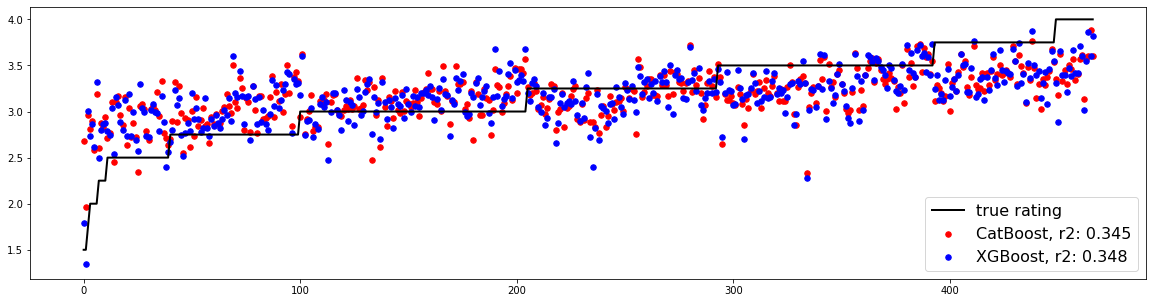

In [78]:
# рисуем результат CatBoost и XGBoost
# отсортируем данные по значению целевой переменной, затем по проценту шоколада, затем по количеству ингр, затем по количеству продуктом

# датасет с реальным рейтингом и no_products, cocoa_percent
df_res = X_test.loc[:,['no_products', 'cocoa_percent', 5, 4]]
df_res['y_true'] = y_test
df_res['y_pred_rf'] = y_pred_rf
df_res['y_pred_cb'] = y_pred_cb
df_res['y_pred_xgb'] = dpred
df_res['y_pred_mean'] = (y_pred_cb + dpred)/2
df_res = df_res.sort_values(by = ['y_true', 'no_products'])
df_res = df_res.reset_index()
plt.figure(figsize = (20, 5))
plt.plot(df_res['y_true'], c = 'black', linewidth = 2, label = 'true rating')
#rf_label = 'Random Forest, r2:  ' + '{:.2f}'.format(metrics.r2_score(y_test, y_pred_rf))
#plt.scatter(x = df_res.index, y = df_res['y_pred_mean'], c = 'green', s = 30, label = 'y_pred_mean')
cb_label = 'CatBoost, r2: ' + '{:.3f}'.format(metrics.r2_score(y_test, y_pred_cb))
plt.scatter(x = df_res.index, y = df_res['y_pred_cb'], c = 'red', s = 30, label = cb_label)
xgb_label = 'XGBoost, r2: ' + '{:.3f}'.format(metrics.r2_score(y_test, dpred))
plt.scatter(x = df_res.index, y = df_res['y_pred_xgb'], c = 'blue', s = 30, label = xgb_label)
plt.legend(loc = 'lower right', prop={'size': 16})
plt.show()
# выводы по картинке: предсказание, конечно, лучше среднего, но ненамного.
# dвизуально видно, что предсказание тяготеет к среднему
# также заметно, что предсказанный рейтинг увеличивается при росте количества продуктов, выпускаемых данной фирмой

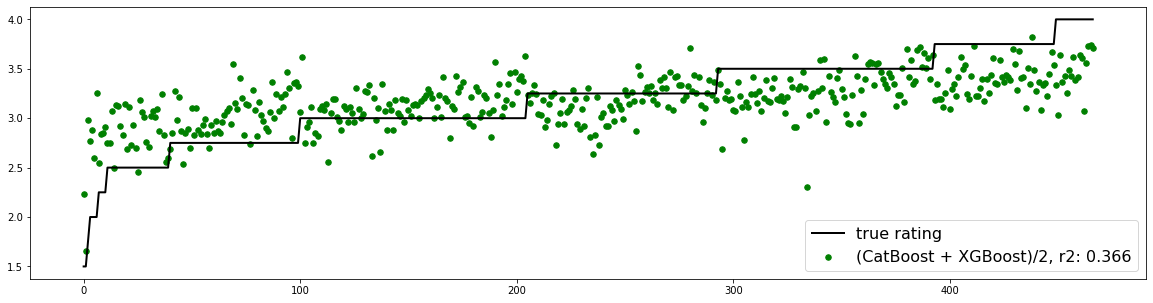

In [79]:
# Нарисуем результат усреднений CatBoost и XGBoost
plt.figure(figsize = (20, 5))
plt.plot(df_res['y_true'], c = 'black', linewidth = 2, label = 'true rating')
mean_label = '(CatBoost + XGBoost)/2, r2: ' + '{:.3f}'.format(metrics.r2_score(y_test, (y_pred_cb + dpred)/2))
plt.scatter(x = df_res.index, y = df_res['y_pred_mean'], c = 'green', s = 30, label = mean_label)

plt.legend(loc = 'lower right', prop={'size': 16})
plt.show()

### Иллюстрация, как изменялись результаты Катбуста и рандомФореста с добавлением новых признаков:

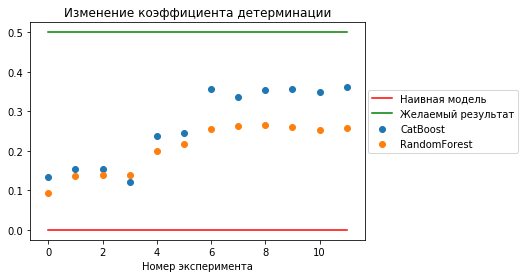

In [80]:
# результирующие метрики для разных наборов столбцов взяты из ручных заметок
r2_score_CatBoost = [0.13483,0.1529,0.15298,0.12238,0.23673,0.24427,0.35544,0.33687,0.35334,0.3563,0.34979, 0.36058]
r2_score_RF = [0.09452,0.13635,0.13802,0.13802,0.20011,0.2183,0.25597,0.26266,0.26417,0.25977,0.25317, 0.25707]

N = len(r2_score_CatBoost)
data_preprocs = ['new_01','new_02','new_03','new_05_cat','new_06','new_06_cat','new_07','new_08','new_09_cat','new_09_cat','new_10_cat',
                'new_11_cat']
plt.plot(range(N), np.zeros(N), label = 'Наивная модель', c = 'red')
plt.scatter(y = r2_score_CatBoost, x = range(N), label = 'CatBoost')
plt.scatter(y = r2_score_RF, x = range(N), label = 'RandomForest')
plt.plot(range(N), 0.5*np.ones(N), c = 'green', label = 'Желаемый результат')
plt.title('Изменение коэффициента детерминации')
plt.xlabel('Номер эксперимента')
plt.legend(loc = (1.01, 0.4))
plt.show()


На графике показана результирующая метрика для моделей случайного леса и катбуста.
Видно 2 улучшения:  
- с 10 до 20% на 4м эксперименте, --> Страна ограничена 30 уникальными, и добавлено количество продуктов для фирмы
- с 20 до 34% на 6м эксперименте --> добавлена обработка (keras Tokenizer) столбца с описанием вкуса

Идеи дальше:


1. Попробовать DL с разными архитектурами применительно к задаче классификации
2. Новые потенциальные признаки: 
    - придумать какое-нибудь число, характеризующее страну произрастания: количетсво солнечных дней, количество осадков, широту

3. Подумать про визуализацию признаков через PCA. Например, нарисовать трехмерный график и там цветом выделить хороший и плохой шоколад

